In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Facial Expressions Detection - FER2013**

- [Importing the Libraries](#improting-the-libraries)
- [Prepare dataset](#Import-train-and-test-and-perform-data-preprocessing)
- [Chosen model 1: Customized CNN](#[Chosen]-Conventional-CNN)
- [Chosen model 2: VGG16 + Softmax](#[Chosen]-VGG16-Softmax)
- [Chosen model 3: VGG16 + Dropout + Dense + Softmax](#[Chosen]-VGG16-Dropout-Dense-Softmax)
- [LIME Interpretation for Customized CNN](#LIME)

# Improting the libraries

In [1]:
# import libray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import tensorflow as tf
import keras
from keras import regularizers
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization, Activation, Input

from tensorflow.keras import activations
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import itertools

In [2]:
tf.random.set_seed(42)

# Import train and test and perform data preprocessing

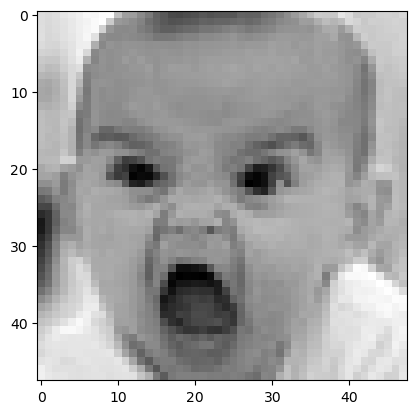

In [ ]:
# randomly checking 1 image
import tensorflow as tf
from tensorflow.keras.preprocessing import image

img = image.load_img('/kaggle/input/fer2013/train/angry/Training_143373.jpg', target_size=(48,48))
plt.imshow(img)

In [ ]:
# define train and test path
train_dir = "/kaggle/input/fer2013/train" #passing the path with training images
test_dir = "/kaggle/input/fer2013/test"   #passing the path with testing images

# set up original image size

img_size = 48 #original size of the image

## Data Augmentation

In [ ]:
# Data Augmentation
# --------------------------
# rotation_range = rotates the image with the amount of degrees we provide
# width_shift_range = shifts the image randomly to the right or left along the width of the image
# height_shift range = shifts image randomly to up or below along the height of the image
# horizontal_flip = flips the image horizontally
# rescale = to scale down the pizel values in our image between 0 and 1
# zoom_range = applies random zoom to our object
# validation_split = reserves some images to be used for validation purpose

train_datagen = ImageDataGenerator( horizontal_flip = True,
                                    brightness_range=(0.2,1.0),
                                    rescale=1./255,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split = 0.2
                                    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

In [ ]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch_size,
                                                    # color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42,
                                                    subset = "training"
                                                   )
validation_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch_size,
                                                    # color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42,
                                                    subset = "validation"
                                                   )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
#validation data
test_generator = test_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = batch_size,
                                                              # color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle=False
                                                             )

Found 7178 images belonging to 7 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
train_generator.labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
# to plot the validation dataset confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# from sklearn.utils import class_weight
# Compute class weights to balance the classes
class_weights = dict(zip(range(7), (np.sum(train_generator.classes == i) for i in range(7))))
total_samples = np.sum(list(class_weights.values()))
for key in class_weights: #0-6
    class_weights[key] = (1 / class_weights[key]) * (total_samples / 7)

In [ ]:
class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.8260681916271041,
 5: 0.8491570541259983,
 6: 1.2933160650937554}

In [ ]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [ ]:
#create callbacl list for model training
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', 
                               min_delta = 0.00005, 
                               patience = 10,
                               verbose = 1, 
                               restore_best_weights = True,)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_categorical_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks_list = [early_stopping, reduce_learningrate]
epochs = 50

# [Chosen] Conventional CNN

In [ ]:
# from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU

In [ ]:
def cnn_model():
  model = Sequential()

  # Block 1
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3), name="conv1_1"))
  model.add(BatchNormalization(name='batchnorm_1'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name="conv1_2"))
  model.add(BatchNormalization(name='batchnorm_2'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_1"))
  model.add(Dropout(0.3, name='dropout_1'))
  
  # Block 2
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_1"))
  model.add(BatchNormalization(name='batchnorm_3'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_2"))
  model.add(BatchNormalization(name='batchnorm_4'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_2"))
  model.add(Dropout(0.3, name='dropout_2'))

  # Block 3
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_1"))
  model.add(BatchNormalization(name='batchnorm_5'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_2"))
  model.add(BatchNormalization(name='batchnorm_6'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_3"))
  model.add(BatchNormalization(name='batchnorm_7'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_3"))
  model.add(Dropout(0.3, name='dropout_3'))

  # Block 4
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_1"))
  model.add(BatchNormalization(name='batchnorm_8'))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_2"))
  model.add(BatchNormalization(name='batchnorm_9'))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_3"))
  model.add(BatchNormalization(name='batchnorm_10'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_4"))
  model.add(Dropout(0.3, name='dropout_4'))
    
  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(256, activation='relu', name="fc_3"))
  model.add(Dense(128, activation='relu', name="fc_4"))
  model.add(Dropout(0.6, name='dropout_5'))
  model.add(Dense(7, activation='softmax', name='output'))

  return model

In [ ]:
# epochs = 30
batch_size = 64

In [ ]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    callbacks=callbacks_list, 
                    verbose=1)

# history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/50


2023-04-22 18:57:33.304476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


718/718 [==============================] - 180s 232ms/step - loss: 1.9576 - accuracy: 0.0000e+00 - binary_accuracy: 0.8533 - categorical_accuracy: 0.2079 - precision: 0.1892 - recall: 0.0082 - auc: 0.6043 - val_loss: 1.8162 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8571 - val_categorical_accuracy: 0.2517 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6496 - lr: 1.0000e-04
Epoch 2/50
718/718 [==============================] - 62s 86ms/step - loss: 1.8587 - accuracy: 0.0000e+00 - binary_accuracy: 0.8569 - categorical_accuracy: 0.2267 - precision: 0.2763 - recall: 9.1432e-04 - auc: 0.6269 - val_loss: 1.8219 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8571 - val_categorical_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6497 - lr: 1.0000e-04
Epoch 3/50
718/718 [==============================] - 63s 88ms/step - loss: 1.8403 - accuracy: 0.0000e+00 - binary_accuracy: 0.8570 - categorical_accuracy: 0.2426 - precision: 0.2

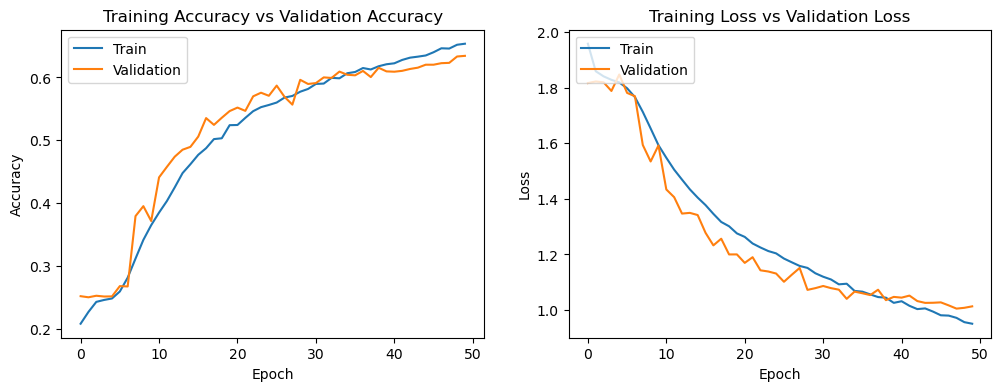

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['categorical_accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

225/225 - 36s - 36s/epoch - 158ms/step


              precision    recall  f1-score   support

       Angry       0.56      0.59      0.57       958
     Disgust       0.53      0.40      0.45       111
        Fear       0.52      0.28      0.36      1024
       Happy       0.87      0.87      0.87      1774
     Neutral       0.54      0.72      0.62      1233
         Sad       0.51      0.57      0.54      1247
    Surprise       0.80      0.71      0.75       831

    accuracy                           0.64      7178
   macro avg       0.62      0.59      0.60      7178
weighted avg       0.65      0.64      0.64      7178



Normalized confusion matrix
[[5.90814196e-01 1.77453027e-02 5.11482255e-02 3.13152401e-02
  1.41962422e-01 1.50313152e-01 1.67014614e-02]
 [4.23423423e-01 3.96396396e-01 2.70270270e-02 3.60360360e-02
  2.70270270e-02 9.00900901e-02 0.00000000e+00]
 [1.59179688e-01 1.07421875e-02 2.77343750e-01 2.83203125e-02
  1.51367188e-01 2.97851562e-01 7.51953125e-02]
 [

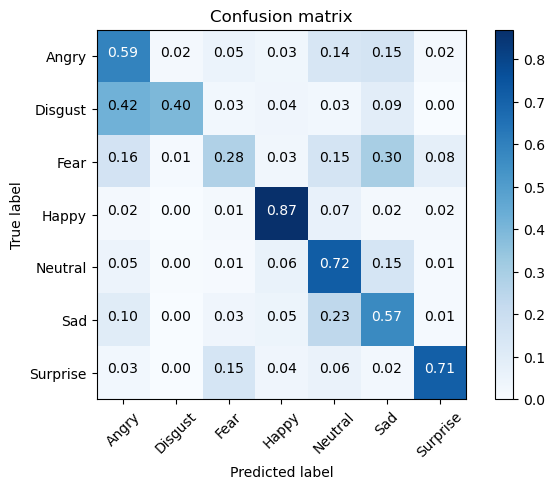

In [ ]:
Y_pred = model.predict(test_generator, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
print('\n')
target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print('\n')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes=target_names,normalize=True)

In [ ]:
model.save('model_cnn.h5')

# VGG

## [Chosen] VGG16 Softmax
Freeze the top layers, update the weights of the last 4 layers, and compile with class weights

In [ ]:
#set up pre-trained vgg16
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")
#base model set all layers parameter non trainable
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(48,48,3)) #input layer is input size 

base_model = base_model(input)

x = Flatten()(base_model) #flatten

pred = Dense(7, activation='softmax')(x) # 7 outputs

model_2 = Model(inputs=input, outputs=pred)

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
train_generator.samples/train_generator.batch_size

358.875

In [ ]:
# from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model_2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=METRICS
)

history_2 = model_2.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/validation_generator.batch_size,
        callbacks=callbacks_list, 
        verbose=1,
        class_weight=class_weights)

Epoch 1/50
358/358 [==============================] - 76s 208ms/step - loss: 2.0497 - accuracy: 0.0000e+00 - binary_accuracy: 0.8646 - categorical_accuracy: 0.1860 - precision: 0.7909 - recall: 0.0707 - auc: 0.5662 - val_loss: 1.9937 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8571 - val_categorical_accuracy: 0.1200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4853 - lr: 1.0000e-04
Epoch 2/50
358/358 [==============================] - 73s 204ms/step - loss: 1.9509 - accuracy: 0.0000e+00 - binary_accuracy: 0.8571 - categorical_accuracy: 0.1436 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5189 - val_loss: 1.9350 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8571 - val_categorical_accuracy: 0.1669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5489 - lr: 1.0000e-04
Epoch 3/50
358/358 [==============================] - 73s 202ms/step - loss: 1.9199 - accuracy: 0.0000e+00 - binary_accuracy: 0.8572 - categorical_accuracy: 0.1714 

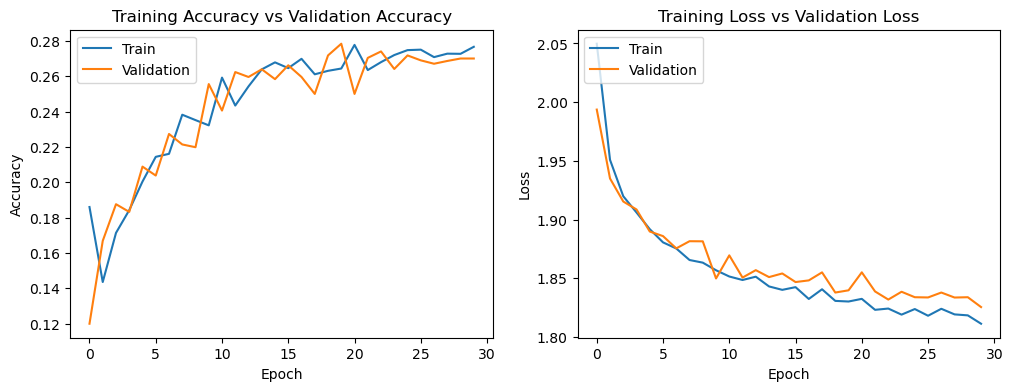

In [ ]:
#visualize
fig , ax = plt.subplots(1,2)
train_acc = history_2.history["categorical_accuracy"]
train_loss = history_2.history["loss"]
fig.set_size_inches(12,4)

ax[0].plot(history_2.history["categorical_accuracy"])
ax[0].plot(history_2.history["val_categorical_accuracy"])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_2.history['loss'])
ax[1].plot(history_2.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

113/113 - 10s - 10s/epoch - 93ms/step


              precision    recall  f1-score   support

       Angry       0.27      0.16      0.20       958
     Disgust       0.06      0.18      0.09       111
        Fear       0.25      0.14      0.18      1024
       Happy       0.41      0.47      0.44      1774
     Neutral       0.30      0.33      0.32      1233
         Sad       0.41      0.17      0.24      1247
    Surprise       0.30      0.65      0.41       831

    accuracy                           0.32      7178
   macro avg       0.29      0.30      0.27      7178
weighted avg       0.33      0.32      0.30      7178

n
Normalized confusion matrix
[[0.16179541 0.05636743 0.07306889 0.28601253 0.1743215  0.06680585
  0.18162839]
 [0.16216216 0.18018018 0.03603604 0.21621622 0.18018018 0.0990991
  0.12612613]
 [0.06152344 0.05078125 0.13769531 0.19433594 0.14257812 0.07714844
  0.3359375 ]
 [0.05524239 0.03776776 0.05806088 0.47181511 0.1572717  0.04509583
  0.17474634]
 [0.07

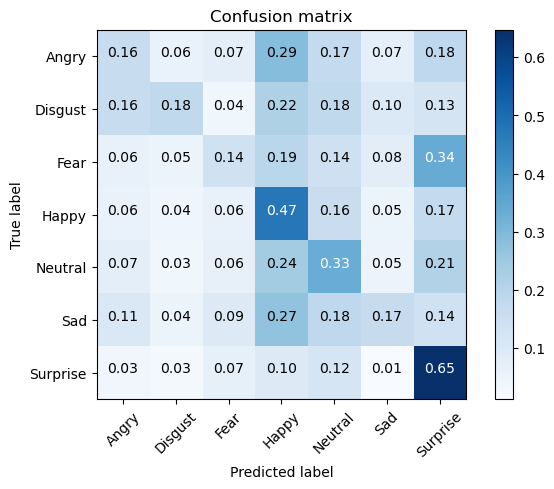

In [ ]:
Y_pred_2 = model_2.predict(test_generator, verbose=2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)
print('\n')
print(classification_report(test_generator.classes, y_pred_2, target_names=target_names))
print('n')
cm = confusion_matrix(test_generator.classes, y_pred_2)
plot_confusion_matrix(cm, classes=target_names, normalize=True)

In [ ]:
model_2.save('model_2.h5')

## [Chosen] VGG16 Dropout Dense Softmax 
Freeze the top layers, update the weights of the last 4 layers, add 3 dense layers 4096, and compile with class weights

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
input = Input(shape=(48,48,3)) #input layer is input size 

base_model = base_model(input)

x = Flatten()(base_model) #flatten
x = Dropout(0.3)(x)  # add dropout layer with a rate of 0.5

x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)

pred = Dense(7, activation='softmax')(x) # 7 outputs

model_3 = Model(inputs=input, outputs=pred)


In [ ]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4096)              2101248   
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_3 (Dense)             (None, 7)                 2867

In [ ]:
# from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model_3.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=METRICS
)

history_3 = model_3.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/validation_generator.batch_size,
        callbacks=callbacks_list, 
        verbose=1,
        class_weight=class_weights)

Epoch 1/50
358/358 [==============================] - 78s 209ms/step - loss: 1.9254 - accuracy: 0.0000e+00 - binary_accuracy: 0.8574 - categorical_accuracy: 0.1678 - precision: 0.5426 - recall: 0.0102 - auc: 0.5863 - val_loss: 1.9171 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8573 - val_categorical_accuracy: 0.1390 - val_precision: 1.0000 - val_recall: 0.0014 - val_auc: 0.5564 - lr: 1.0000e-04
Epoch 2/50
358/358 [==============================] - 75s 208ms/step - loss: 1.8860 - accuracy: 0.0000e+00 - binary_accuracy: 0.8579 - categorical_accuracy: 0.1455 - precision: 0.5834 - recall: 0.0190 - auc: 0.5754 - val_loss: 1.8280 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8581 - val_categorical_accuracy: 0.2808 - val_precision: 0.8125 - val_recall: 0.0091 - val_auc: 0.6752 - lr: 1.0000e-04
Epoch 3/50
358/358 [==============================] - 73s 205ms/step - loss: 1.8585 - accuracy: 0.0000e+00 - binary_accuracy: 0.8587 - categorical_accuracy: 0.1923 - precision: 0.6246 - re

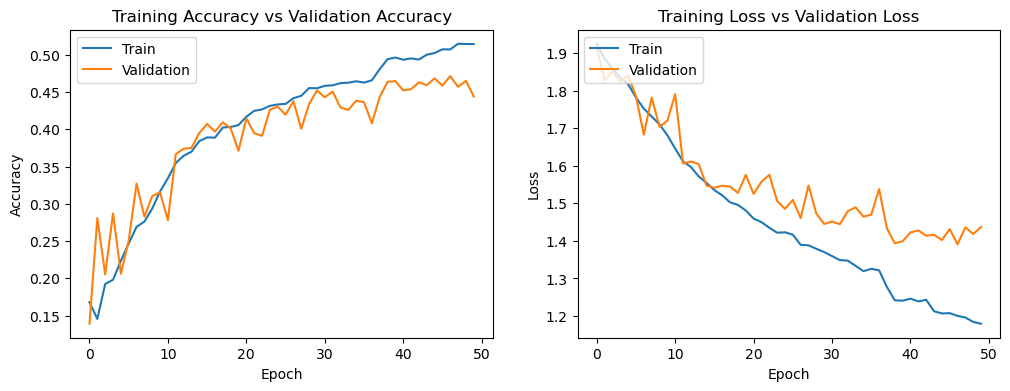

In [ ]:
#visualize
fig , ax = plt.subplots(1,2)
train_acc = history_3.history["categorical_accuracy"]
train_loss = history_3.history["loss"]
fig.set_size_inches(12,4)

ax[0].plot(history_3.history["categorical_accuracy"])
ax[0].plot(history_3.history["val_categorical_accuracy"])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history_3.history['loss'])
ax[1].plot(history_3.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

113/113 - 11s - 11s/epoch - 98ms/step


              precision    recall  f1-score   support

       Angry       0.46      0.42      0.44       958
     Disgust       0.19      0.61      0.29       111
        Fear       0.43      0.29      0.35      1024
       Happy       0.78      0.65      0.71      1774
     Neutral       0.42      0.62      0.50      1233
         Sad       0.49      0.36      0.42      1247
    Surprise       0.62      0.76      0.68       831

    accuracy                           0.53      7178
   macro avg       0.48      0.53      0.48      7178
weighted avg       0.55      0.53      0.53      7178



Normalized confusion matrix
[[0.41962422 0.06993737 0.07515658 0.05949896 0.217119   0.10542797
  0.05323591]
 [0.13513514 0.61261261 0.02702703 0.07207207 0.09009009 0.04504505
  0.01801802]
 [0.13085938 0.046875   0.29492188 0.04882812 0.17773438 0.13671875
  0.1640625 ]
 [0.05411499 0.03043968 0.0253664  0.64994363 0.14317926 0.0535513
  0.04340474]
 [0.06

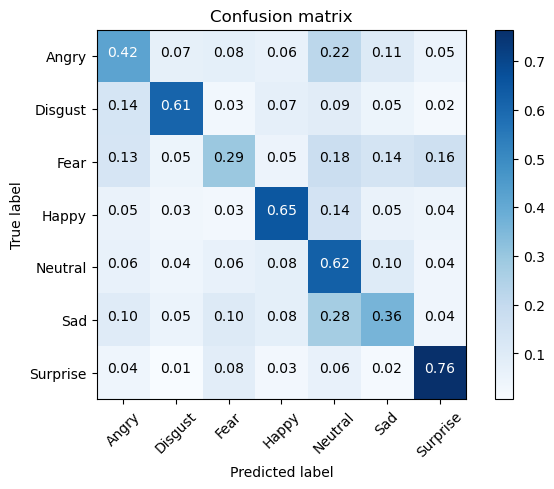

In [ ]:
Y_pred_3 = model_3.predict(test_generator, verbose=2)
y_pred_3 = np.argmax(Y_pred_3, axis=1)
print('\n')
print(classification_report(test_generator.classes, y_pred_3, target_names=target_names))
print('\n')
cm = confusion_matrix(test_generator.classes, y_pred_3)
plot_confusion_matrix(cm, classes=target_names,normalize=True)

In [ ]:
model_3.save('model_3.h5')

# LIME

## Reading file from Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
%cd /content/gdrive/MyDrive/MSBA/Sem2/BT5153/Project/

/content/gdrive/MyDrive/MSBA/Sem2/BT5153/Project


In [18]:
ls

archive.zip                 model_cnn.h5          VGG_julie.ipynb
Group15_CNN_VGG_LIME.ipynb  moodvision_VGG.ipynb


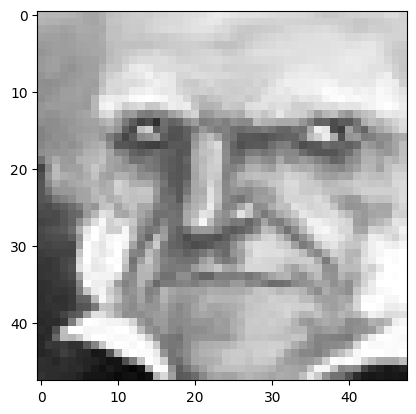

In [19]:
# randomly checking 1 image
import tensorflow as tf
from tensorflow.keras.preprocessing import image

img = image.load_img('test/PrivateTest_11149326.jpg', target_size=(48,48))
plt.imshow(img)

## Loading pre-trained Customized CNN

In [20]:
model_cnn = keras.models.load_model('model_cnn.h5')

## Start with LIME

In [21]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=e929f11f372566a39768712b80f0625c0afc28e10b6d0ddacbc7b9f3707c5668
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
import lime
import lime.lime_image

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions


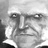

In [22]:

# img_path = 'test/PrivateTest_10613684.jpg' # Happy
img_path = 'test/PrivateTest_11149326.jpg' #Sad
# import image to be array
from PIL import Image
img = Image.open(img_path)
img_array = np.asarray(img)

img

In [23]:
# normalize the image
class_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
IMG_SIZE = (48, 48)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(img_path, IMG_SIZE)

# get the model prediction using normalized image

model_prediction = model_cnn.predict(normalized_img)

#customize the decode function to 7 classes
def decode_predictions_custom(output, class_names):
    results = []
    for i, prob in enumerate(output[0]):
        class_name = class_names[i]
        results.append((class_name, "", '{:.4%}'.format(prob)))
    return results

# output = model_3.predict(img)
predictions = decode_predictions_custom(model_prediction, class_names)

1/1 [==============================] - 7s 7s/step


In [24]:
predictions

# checking prediction ranking which might been used in LIME

[('Angry', '', '76.2852%'),
 ('Disgust', '', '1.2163%'),
 ('Fear', '', '3.6274%'),
 ('Happy', '', '0.2735%'),
 ('Neutral', '', '8.9540%'),
 ('Sad', '', '9.5080%'),
 ('Surprise', '', '0.1356%')]

In [25]:
from lime import lime_image
import time
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(normalized_img[0], model_cnn.predict,  
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


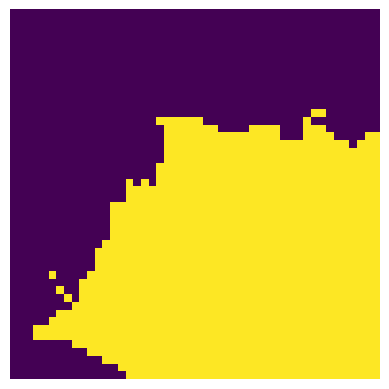

In [26]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

(-0.5, 47.5, 47.5, -0.5)

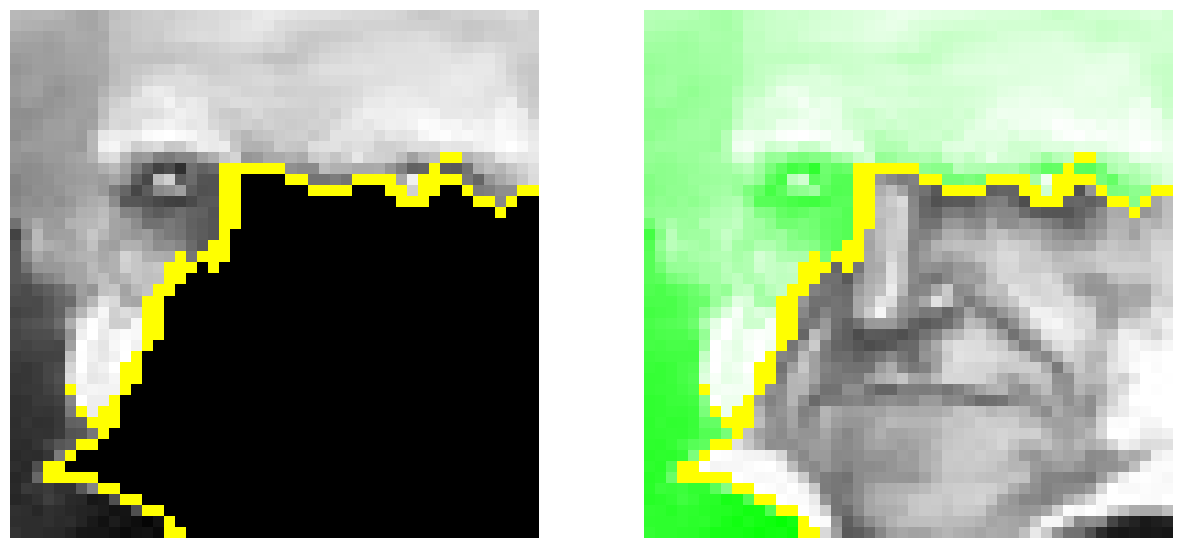

In [27]:
from skimage.segmentation import mark_boundaries
weight = 0.3

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10,hide_rest=True, min_weight=weight )
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False, min_weight=weight)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

# We can also see the 'pros and cons' (pros in green, cons in red)